In [242]:
# Load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import math as math

%matplotlib inline

In [243]:
data = pd.read_csv('per_station/519.csv')
print('Len', len(data))
print(data.columns)

Len 4789
Index(['Unnamed: 0', 'eightd_has_available_keys', 'is_installed', 'is_renting',
       'is_returning', 'last_reported', 'num_bikes_available',
       'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled',
       'station_id', 'weather_ts', 'apparentTemperature', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'nearestStormBearing',
       'nearestStormDistance', 'ozone', 'precipIntensity',
       'precipIntensityError', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'time', 'visibility', 'windBearing',
       'windSpeed', 'traffic_0_asof', 'traffic_0_distance', 'traffic_0_linkId',
       'traffic_0_speed', 'traffic_0_travel_time', 'traffic_1_asof',
       'traffic_1_distance', 'traffic_1_linkId', 'traffic_1_speed',
       'traffic_1_travel_time', 'traffic_2_asof', 'traffic_2_distance',
       'traffic_2_linkId', 'traffic_2_speed', 'traffic_2_travel_time', 'y_10m',
       'y_15m', 'y_30m', 'y_45m', 'y_60m', 'y_90m', 'y_120m'],
 

In [149]:
def parse_datetime(df):
    # Turn date columns from string to datetime64
    date_columns = [
        'last_reported',
        'traffic_0_asof',
        'traffic_1_asof',
        'traffic_2_asof'
    ]
    for c in date_columns:
        df[c] = pd.to_datetime(df[c], infer_datetime_format=True)

def scale_bikes_and_docks(data, capacity):
    data['num_bikes_available_scaled'] = data['num_bikes_available'] / capacity
    data['num_bikes_disabled_scaled'] = data['num_bikes_disabled'] / capacity
    data['num_docks_available_scaled'] = data['num_docks_available'] / capacity
    data['num_docks_disabled_scaled'] = data['num_docks_disabled'] / capacity
    
def get_time_features(df):
    df['day_of_week'] = df['last_reported'].dt.dayofweek
    df['hour_of_day'] = df['last_reported'].dt.hour + df['last_reported'].dt.minute / 60
    df['is_weekend'] = (df['day_of_week'] >= 5) * 1.0

parse_datetime(data)
scale_bikes_and_docks(data, 61)
get_time_features(data)

In [150]:
def drop_columns(data):
    return data.drop([
            'Unnamed: 0',
            'eightd_has_available_keys',
            'summary',
            'traffic_0_linkId',
            'traffic_1_linkId',
            'traffic_2_linkId',
            'traffic_0_asof', # no longer useful
            'traffic_1_asof',
            'traffic_2_asof',
            'traffic_0_speed', # unclean speeds
            'traffic_1_speed',
            'traffic_2_speed',
            'time',
            'icon',
            'weather_ts',
            'is_installed',
            'is_renting',
            'is_returning',
            'nearestStormBearing',
            'precipIntensityError',
            'precipType',
            'num_bikes_available',
            'num_docks_available',
            'num_bikes_disabled',
            'num_docks_disabled',
            'num_docks_disabled',
            
            'last_reported',
            'station_id',
            
            'traffic_0_distance',
            'traffic_1_distance',
            'traffic_2_distance',
            'traffic_0_travel_time',
            'traffic_1_travel_time',
            'traffic_2_travel_time',
            'y_10m',
            'y_15m',
            'y_30m',
            'y_45m',
            #'y_60m',
            'y_90m',
            'y_120m',
        ], axis=1)
data_drop = drop_columns(data)
print(data_drop.as_matrix().shape)
print(data_drop.columns)
data_drop[:3]

(4789, 22)
Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'nearestStormDistance', 'ozone', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
       'y_60m', 'num_bikes_available_scaled', 'num_bikes_disabled_scaled',
       'num_docks_available_scaled', 'num_docks_disabled_scaled',
       'day_of_week', 'hour_of_day', 'hour_only', 'is_weekend'],
      dtype='object')


,apparentTemperature,cloudCover,dewPoint,humidity,nearestStormDistance,ozone,precipIntensity,precipProbability,pressure,temperature,...,windSpeed,y_60m,num_bikes_available_scaled,num_bikes_disabled_scaled,num_docks_available_scaled,num_docks_disabled_scaled,day_of_week,hour_of_day,hour_only,is_weekend
0,77.33,0.51,62.13,0.60,16,280.78,0.0,0.0,1013.38,77.33,...,3.43,0.196429,0.098361,0.081967,0.819672,0.0,0,13.683333,13,0.0
1,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,4.81,0.250000,0.032787,0.081967,0.885246,0.0,0,13.816667,13,0.0
2,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,4.81,0.214286,0.098361,0.081967,0.819672,0.0,0,13.900000,13,0.0


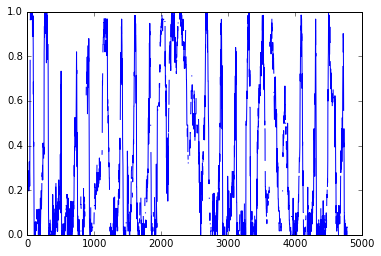

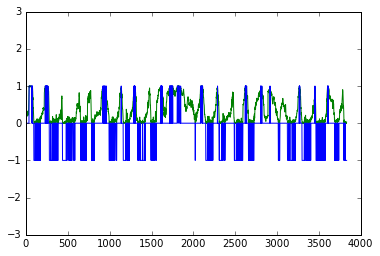

Cleaned data size: 3832


,count,mean,std,min,25%,50%,75%,max
apparentTemperature,3832.0,56.968411,10.669506,31.560000,50.210000,56.280000,65.590000,84.620000
cloudCover,3832.0,0.342756,0.304348,0.000000,0.080000,0.260000,0.560000,1.000000
dewPoint,3832.0,44.664653,11.671458,24.970000,34.805000,42.195000,55.090000,68.490000
humidity,3832.0,0.629105,0.140517,0.350000,0.520000,0.610000,0.720000,0.950000
nearestStormDistance,3832.0,73.985647,130.291373,0.000000,7.000000,19.000000,66.500000,829.000000
ozone,3832.0,279.242067,13.675113,246.790000,270.525000,276.630000,287.205000,315.310000
precipIntensity,3832.0,0.001480,0.012651,0.000000,0.000000,0.000000,0.000000,0.403900
precipProbability,3832.0,0.047508,0.201815,0.000000,0.000000,0.000000,0.000000,1.000000
pressure,3832.0,1016.246975,30.282454,419.850000,1012.670000,1019.230000,1023.190000,1031.170000
temperature,3832.0,57.748022,9.631278,38.070000,50.210000,56.280000,65.590000,83.620000


In [282]:
def bucket_y_variable(data_drop, threshold_empty=.05, threshold_full=.95):
    y_60m = data_drop['y_60m'].copy()
    y_60m[y_60m < 0] = None
    plt.figure()
    plt.plot(y_60m)
    plt.show()

    data_valid = data_drop[data_drop['y_60m'] >= 0].copy()
    yvar = np.zeros(len(data_valid))
    yvar[(data_valid['y_60m'] < threshold_empty).as_matrix()] = -1
    yvar[(data_valid['y_60m'] > threshold_full).as_matrix()] = 1
    data_valid['y'] = yvar
    plt.figure()
    plt.plot(data_valid['y_60m'].as_matrix(), 'g')
    plt.plot(yvar, 'b')
    plt.ylim(-3, 3)
    plt.show()

    return data_valid.drop(['y_60m'], axis=1)

#data_cleaned = bucket_y_variable(data_drop)
data_cleaned = bucket_y_variable(data_drop, threshold_empty=0.05, threshold_full=0.95)
print('Cleaned data size:', len(data_cleaned))
data_cleaned.describe().T

In [291]:
#Note: false positive = predicted as available but actually empty. 
#does not take into account when we predict is available but is full

#predict available and compare accuracy
def predict_available(data, y):
    available = np.empty(len(data[y]));
    available.fill(0)
    accu_avail = sklearn.metrics.accuracy_score(data[y], available)
    cm_avail = sklearn.metrics.confusion_matrix(data[y], available)
    fpr = cm_avail[0][1]/cm_avail[0:2,1].sum()

    return accu_avail, cm_avail, fpr
accu_avail, cm_avail, fpr_avail = predict_available(data_cleaned,'y')
print("Accuracy: {}".format(accu_avail))
print("False Positive Rate: {}".format(fpr_avail))
print(cm_avail)
    

Accuracy: 0.6876304801670147
False Positive Rate: 0.27629772040648176
[[   0 1006    0]
 [   0 2635    0]
 [   0  191    0]]


In [292]:
#Predict current status

def predict_current(data, y):
    
    current = np.zeros(len(data['num_bikes_available_scaled']))
    current[np.array(data['num_bikes_available_scaled']) < 0.05] = -1
    current[np.array(data['num_bikes_available_scaled']) > 0.95] = 1
    accu_current = sklearn.metrics.accuracy_score(data[y], current)
    cm_current = sklearn.metrics.confusion_matrix(data[y], current)
    fpr_current = cm_current[0][1]/cm_current[0:2,1].sum()

    return accu_current, cm_current, fpr_current
accu_current, cm_current, fpr_current = predict_current(data_cleaned,'y')
print("Accuracy: {}".format(accu_current))
print("False Positive Rate: {}".format(fpr_current))
print(cm_current)

Accuracy: 0.7421711899791231
False Positive Rate: 0.14723203769140164
[[ 630  375    1]
 [ 402 2172   61]
 [   0  149   42]]


In [293]:
#Predict average status

def predict_avg(data, y):
    
    data['hour_only'] = np.floor(data['hour_of_day'])

    data.loc[data['hour_only']<23,'hour_pred'] = data['hour_only'] + 1
    data.loc[data['hour_only']<23,'dow_pred'] = data['day_of_week']
    data.loc[data['hour_only']==23,'hour_pred'] = 0
    data.loc[(data['hour_only']==23) & (data['day_of_week']!=7),'dow_pred'] = data['day_of_week'] +1
    data.loc[(data['hour_only']==23) & (data['day_of_week']==7),'dow_pred'] = 0


    grouped_avg = data.groupby(['day_of_week','hour_only'], as_index=False)['num_bikes_available_scaled'].mean().add_prefix('avg_')
    data_merged = pd.merge(data,grouped_avg, how='inner', left_on=['hour_pred','dow_pred'], right_on=['avg_hour_only','avg_day_of_week'])

    avg = np.zeros(len(data_merged['num_bikes_available_scaled']))
    avg[np.array(data_merged['avg_num_bikes_available_scaled']) < 0.05] = -1
    avg[np.array(data_merged['avg_num_bikes_available_scaled']) > 0.95] = 1

    accu_avg = sklearn.metrics.accuracy_score(data_merged[y], avg)
    cm_avg = sklearn.metrics.confusion_matrix(data_merged[y], avg)
    fpr_avg = cm_avg[0][1]/cm_avg[0:2,1].sum()

    data['pred_mean'] = data.groupby(['day_of_week','hour_only'])['num_bikes_available_scaled'].transform(np.mean)
    avg = np.zeros(len(data['num_bikes_available_scaled']))
    avg[np.array(data['pred_mean']) < 0.05] = -1
    avg[np.array(data['pred_mean']) > 0.95] = 1
    

    return accu_avg, cm_avg, fpr_avg,

accu_avg, cm_avg, fpr_avg = predict_avg(data_cleaned,'y')
print("Accuracy: {}".format(accu_avg))
print("False Positive Rate: {}".format(fpr_avg))
print(cm_avg)

Accuracy: 0.7353482260183969
False Positive Rate: 0.21536523929471033
[[ 306  684    0]
 [ 132 2492    0]
 [   0  191    0]]
